In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

sns.set_theme(style="white")

# Change matplotlib font to LaTeX-like
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
df = pd.read_pickle("../data/processed/data_one_day_clean.pickle")
df.head(5)

,Tank-ID,Zeitstempel,Füllstand,Linear Prozentwert,Sensorwert,Leerstand,Maximale Füllgrenze,Temperatur,Sensorlage,PLZ,Breitengrad,Längengrad,Sicherheitsbestand wird erreicht am,Meldebestand wird erreicht am,Verbrauch,Verbrauch smoothed
0,0,2022-10-11,3165.0,32.0,1.48,6835.0,10000.0,21.0,4.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,-13.0,-5.909091
1,0,2022-10-12,3152.0,32.0,1.48,6839.0,10000.0,20.0,3.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,0.0,-5.636364
2,0,2022-10-13,3152.0,32.0,1.48,6848.0,10000.0,20.0,3.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,-4.0,-5.454545
3,0,2022-10-14,3148.0,31.0,1.48,6848.0,10000.0,20.0,3.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,-8.0,-5.590909
4,0,2022-10-15,3140.0,31.0,1.49,6857.0,10000.0,20.0,3.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,-3.0,-6.045455


In [4]:
def get_cleaned_data(path = "../data/processed/data_one_day_clean.pickle") -> tuple[pd.DataFrame, pd.DataFrame]:
    df = pd.read_pickle(path)
    # correct outliers
    df.loc[df['Verbrauch'] > 0, 'Verbrauch'] = 0.0
    # take absolute values
    df['Verbrauch'] = df['Verbrauch'].abs()
    # drop NaN values
    df = df.dropna()
    df_rest = df.drop(['Verbrauch', 'Zeitstempel'], axis=1)
    df = df[["Zeitstempel", "Verbrauch"]]

    return df, df_rest

def fit_linear_model(df: pd.DataFrame, context: int = 90, degree: int = 3, forecast_days: int = 7):
    print(df.columns)
    # Get newest -Days Tage
    y = df["Verbrauch"].iloc[-context:].values.reshape(-1, 1)
    X = np.arange(len(y)).reshape(-1, 1)
    dates = df["Zeitstempel"].iloc[-context:].values
    future_days = pd.date_range(start=dates.max() + pd.Timedelta(days=1), periods=forecast_days, freq="D")

    # Extend feature space to make polynomial regression
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)

    # Fit linear regression with polynomial features
    lr = LinearRegression()
    lr.fit(X_poly, y)
    # Get best fitted line
    y_pred = lr.predict(X_poly)

    # Evaluate best fitted line
    r2 = r2_score(y_true=y, y_pred=y_pred)

    future_days_to_predict = np.arange(X.max(), X.max() + forecast_days).reshape(-1, 1)
    # Get prediction for future days
    future_days_extened = poly.transform(future_days_to_predict)
    y_pred_future = lr.predict(future_days_extened).flatten()

    y_train = pd.DataFrame({"Verbrauch": y.flatten(), "Zeitstempel": dates, "flag": "train"}, index=X.flatten())
    y_pred = pd.DataFrame({"Verbrauch": y_pred.flatten(), "Zeitstempel": dates, "flag": "pred"}, index=X.flatten())
    y_pred_future = pd.DataFrame({"Verbrauch": y_pred_future.flatten(), "Zeitstempel": future_days, "flag": "pred_future"}, index=future_days_to_predict.flatten())

    return y_train, y_pred, y_pred_future

df, df_rest = get_cleaned_data()

y_train, y_pred, y_pred_future = fit_linear_model(df)
y_pred_future

Index(['Zeitstempel', 'Verbrauch'], dtype='object')


,Verbrauch,Zeitstempel,flag
89,6.402748,2024-10-12,pred_future
90,6.484180,2024-10-13,pred_future
91,6.565051,2024-10-14,pred_future
92,6.645312,2024-10-15,pred_future
93,6.724912,2024-10-16,pred_future
94,6.803801,2024-10-17,pred_future
95,6.881930,2024-10-18,pred_future


In [5]:
df_rest

,Tank-ID,Füllstand,Linear Prozentwert,Sensorwert,Leerstand,Maximale Füllgrenze,Temperatur,Sensorlage,PLZ,Breitengrad,Längengrad,Sicherheitsbestand wird erreicht am,Meldebestand wird erreicht am,Verbrauch smoothed
0,0,3165.0,32.0,1.48,6835.00,10000.0,21.0,4.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,-5.909091
1,0,3152.0,32.0,1.48,6839.00,10000.0,20.0,3.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,-5.636364
2,0,3152.0,32.0,1.48,6848.00,10000.0,20.0,3.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,-5.454545
3,0,3148.0,31.0,1.48,6848.00,10000.0,20.0,3.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,-5.590909
4,0,3140.0,31.0,1.49,6857.00,10000.0,20.0,3.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,-6.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,4,5074.0,85.0,0.23,924.18,6000.0,16.0,1.0,77761.0,48.291074,8.324858,12/7/2026,4/29/2026,-6.000000
3140,4,5068.0,84.0,0.23,929.77,6000.0,16.0,1.0,77761.0,48.291074,8.324858,12/7/2026,4/29/2026,-6.000000
3141,4,5062.0,84.0,0.23,934.53,6000.0,16.0,1.0,77761.0,48.291074,8.324858,12/7/2026,4/29/2026,-5.454545
3142,4,5061.0,84.0,0.23,938.42,6000.0,16.0,1.0,77761.0,48.291074,8.324858,12/7/2026,4/29/2026,-5.272727


In [6]:
concat = pd.concat([y_train, y_pred_future])
concat["Zeitstempel"] = pd.to_datetime(concat["Zeitstempel"])
concat

,Verbrauch,Zeitstempel,flag
0,1.000000,2024-07-14,train
1,0.000000,2024-07-15,train
2,0.000000,2024-07-16,train
3,9.000000,2024-07-17,train
4,3.000000,2024-07-18,train
...,...,...,...
91,6.565051,2024-10-14,pred_future
92,6.645312,2024-10-15,pred_future
93,6.724912,2024-10-16,pred_future
94,6.803801,2024-10-17,pred_future


# Test Area

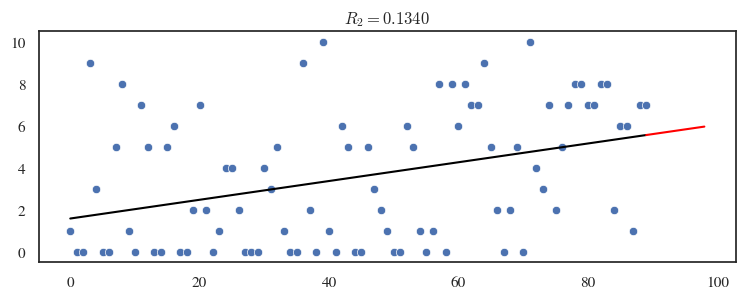

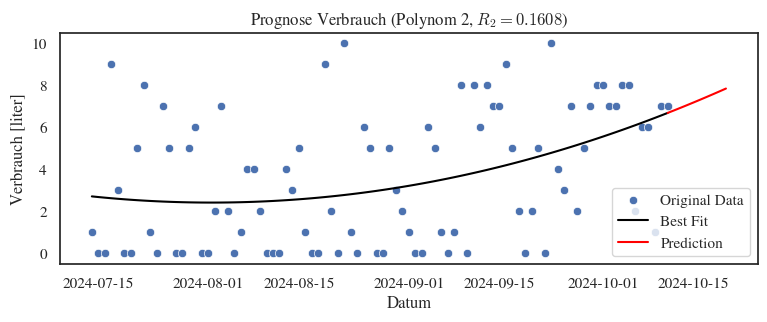

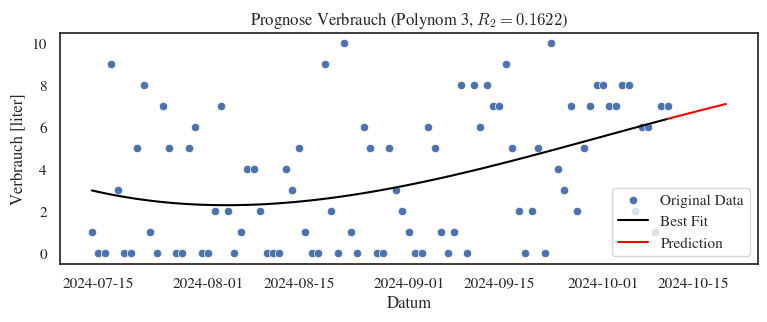

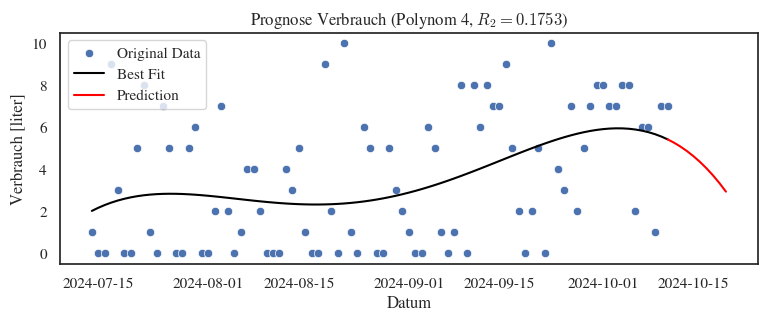

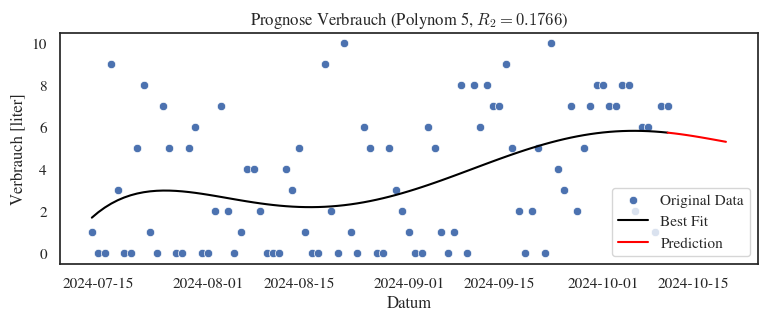

In [7]:
CONTEXT = 90
DEGREE = [1, 2, 3, 4, 5]
FORECAST_DAYS = 10

# Get newest -Days Tage
y = df["Verbrauch"].iloc[-CONTEXT:].values
dates = df["Zeitstempel"].iloc[-CONTEXT:].values
dates = pd.to_datetime(dates, format='datetime64[ns]')
X = np.arange(len(y))

FUTURE_DAYS = np.arange(X.max(), X.max() + FORECAST_DAYS).reshape(-1, 1)
future_days = pd.date_range(start=dates.max() + pd.Timedelta(days=0), periods=FORECAST_DAYS, freq="D")

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

for degree in DEGREE:
    if degree == 1:
        lr = LinearRegression()
        lr.fit(X, y)
        y_pred = lr.predict(X).flatten()
        y_pred_future = lr.predict(FUTURE_DAYS)

        r2 = r2_score(y_true=y, y_pred=y_pred)

        plt.figure(figsize=(9, 3))
        plt.title(f"$R_2 = {r2:.4f}$")
        sns.scatterplot(x=X.flatten(), y=y.flatten())
        sns.lineplot(x=X.flatten(), y=y_pred.flatten(), color="black")
        sns.lineplot(x=FUTURE_DAYS.flatten(), y=y_pred_future.flatten(), color="red")
        plt.show()
    else:
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X)
        lr = LinearRegression()
        lr.fit(X_poly, y)
        y_pred = lr.predict(X_poly)

        r2 = r2_score(y_true=y, y_pred=y_pred)

        future_days_extened = poly.transform(FUTURE_DAYS)
        y_pred_future = lr.predict(future_days_extened).flatten()

        plt.figure(figsize=(9, 3))
        plt.title(f"Prognose Verbrauch (Polynom {degree}, $R_2 = {r2:.4f}$)")
        plt.ylabel("Verbrauch [liter]")
        plt.xlabel("Datum")
        sns.scatterplot(x=dates, y=y.flatten(), label="Original Data")
        sns.lineplot(x=dates, y=y_pred.flatten(), color="black", label="Best Fit")
        sns.lineplot(x=future_days, y=y_pred_future.flatten(), color="red", label="Prediction")
        plt.legend()
        plt.savefig(f"figure_degree_{degree}.png", dpi=256)
        plt.show()
